# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "2n_2m_0f_240216_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [60, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 108000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1727.527664,495.458811,1727.658619,496.333293,NaN,1727.527664,495.458811,NaN,1727.527664,495.458811,-0.002989,4880.0,132.015826,62.921381,0.879109,2
1,1,0,1570.642375,986.308463,1571.390783,984.520214,NaN,1570.642375,986.308463,NaN,1570.642375,986.308463,-1.543950,10374.0,222.382994,92.591304,0.909200,2
2,0,3,1727.514589,495.487452,1727.623350,496.364697,NaN,1727.514589,495.487452,NaN,1727.514589,495.487452,-0.007734,4901.0,131.849388,62.904680,0.878852,2
3,1,3,1571.040946,986.203573,1572.393670,984.357325,NaN,1571.040946,986.203573,NaN,1571.040946,986.203573,-1.543219,10355.0,219.997343,92.764577,0.906753,2


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1]
    ])

    cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
    print("Initial tracking at time 0:\n", tracking_0[cols])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1727.527664,495.458811,1727.658619,496.333293,NaN,1727.527664,495.458811,NaN,1727.527664,495.458811,-0.002989,4880.0,132.015826,62.921381,0.879109,2
1,1,0,1570.642375,986.308463,1571.390783,984.520214,NaN,1570.642375,986.308463,NaN,1570.642375,986.308463,-1.543950,10374.0,222.382994,92.591304,0.909200,2
2,0,3,1727.514589,495.487452,1727.623350,496.364697,NaN,1727.514589,495.487452,NaN,1727.514589,495.487452,-0.007734,4901.0,131.849388,62.904680,0.878852,2
3,1,3,1571.040946,986.203573,1572.393670,984.357325,NaN,1571.040946,986.203573,NaN,1571.040946,986.203573,-1.543219,10355.0,219.997343,92.764577,0.906753,2
4,0,6,1727.522973,495.483766,1727.633026,496.359169,NaN,1727.522973,495.483766,NaN,1727.522973,495.483766,-0.007602,4897.0,131.785410,62.915471,0.878681,2


In [8]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
33014,2,107997,1738.449584,546.642928,1741.552370,558.376127,NaN,1738.449584,546.642928,NaN,1738.449584,546.642928,0.222017,3005.0,178.524643,59.257041,0.943305,7
33015,3,107997,1734.634217,674.322060,1734.464969,673.268974,NaN,1734.634217,674.322060,NaN,1734.634217,674.322060,-0.086540,6564.0,150.107082,67.872899,0.891935,7
33016,4,107997,1336.423736,1045.630341,1334.592593,1045.541258,0.0,1396.000000,1018.000000,0.576471,1388.000000,1079.000000,1.514866,4845.0,248.335829,70.756609,0.958550,7
33017,5,107997,52.308321,1064.397652,52.392726,1064.370711,0.0,50.000000,1044.000000,0.541176,28.000000,1075.000000,-1.464119,1959.0,132.150900,28.598088,0.976304,7
33018,6,107997,815.485421,1066.362384,815.146227,1066.350591,0.0,778.000000,1046.000000,0.666667,800.000000,1047.000000,1.504724,3121.0,170.954999,34.354420,0.979600,7


## Velocities distribution in each frame

In [9]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


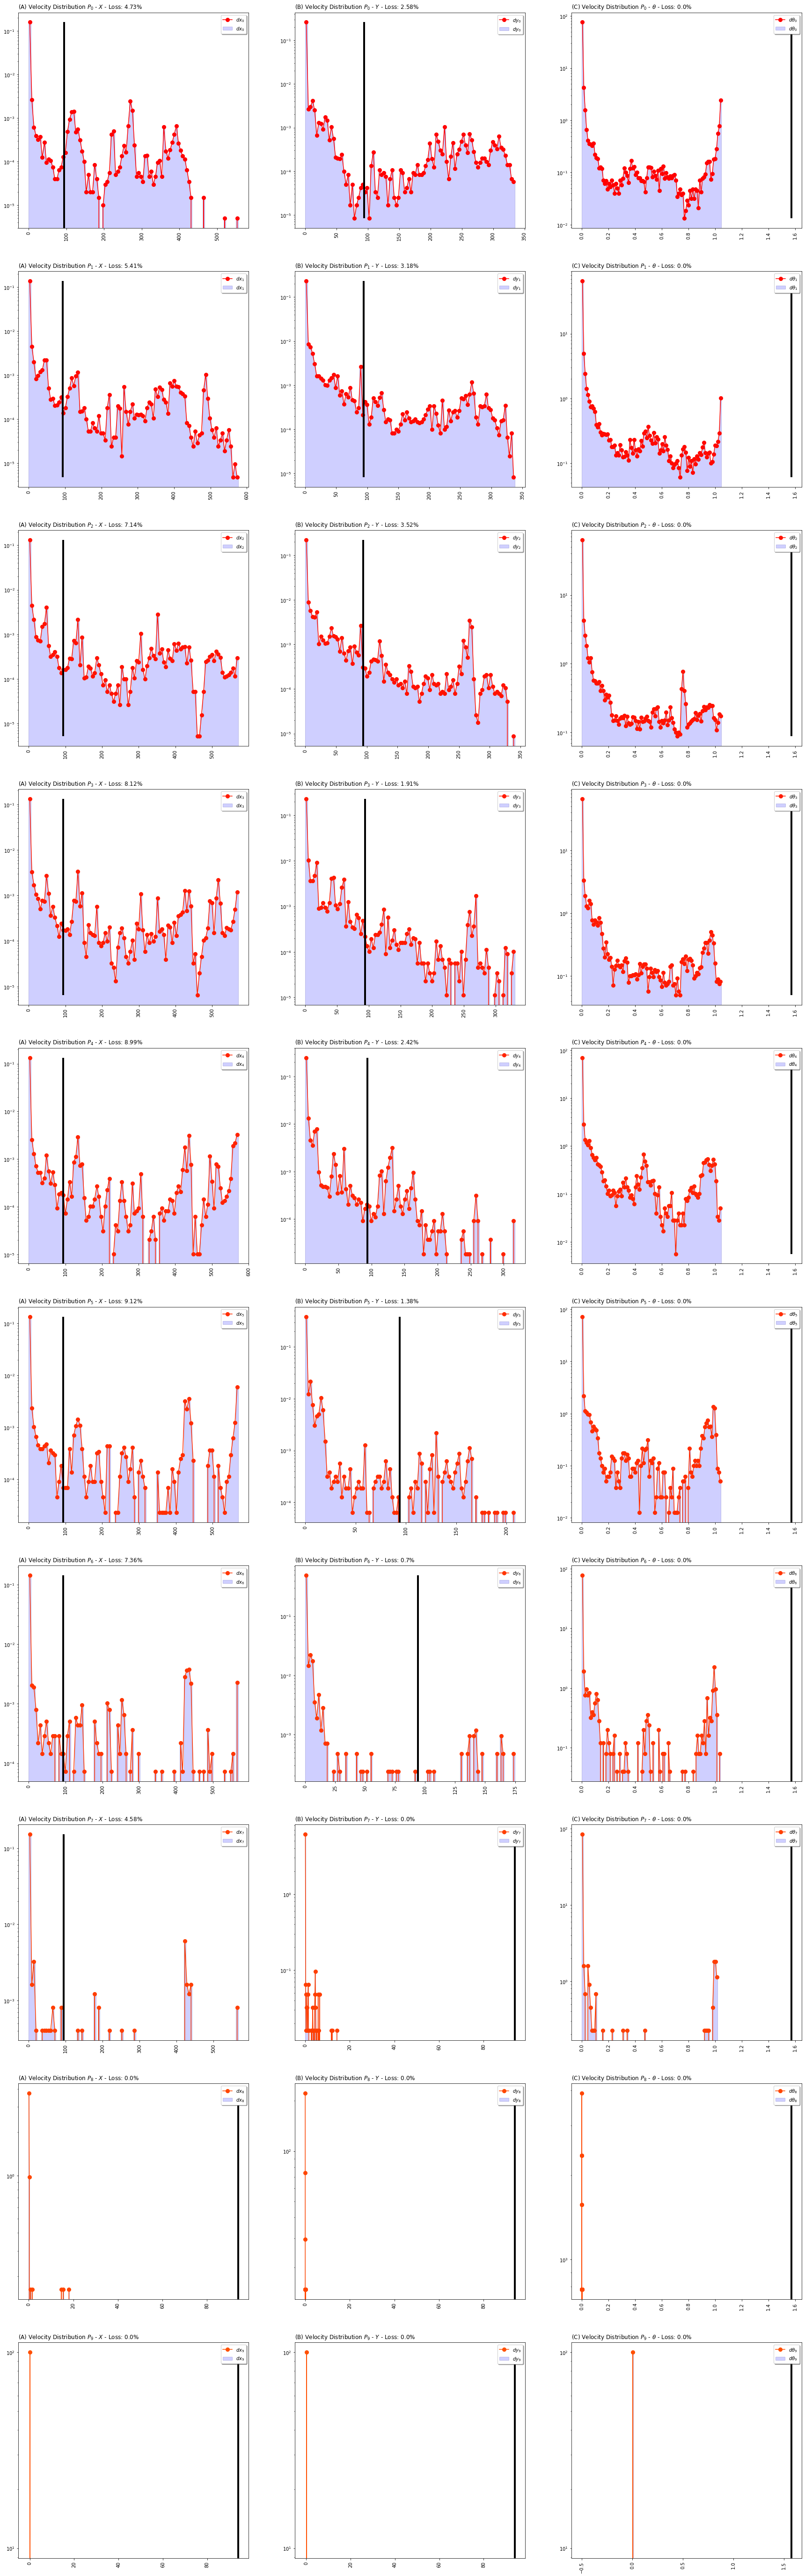

In [10]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [11]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,1,4
1,2,5064
2,3,19965
3,4,39348
4,5,46700
5,6,31284
6,7,13867
7,8,3216
8,9,297
9,10,20


## Clustering frames

In [12]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 53.46991460946566 



In [13]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [14]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,0.001252
1,1,False,True,False,0.001252
2,2,False,False,False,2.932432
3,2,False,True,False,0.107032
4,2,True,False,False,0.024411
5,2,True,True,False,0.105780
6,3,False,False,False,11.450568
7,3,False,True,False,0.317967
8,3,True,False,False,0.439395
9,3,True,True,False,0.288549


In [15]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 12.537116513473556 
	- Angle: 53.46991460946566 



In [16]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 1.946070751216294%
Final loss data X-axis: 1.4128253758830158%
Final loss data Y-axis: 1.0967263131854539%
Final loss data Angle : 0.7737555317335972%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.017866
1,2,False,False,True,0.219895
2,2,False,True,False,0.052225
3,2,False,True,True,0.556609
4,2,True,False,False,0.001374
5,2,True,False,True,0.465903
6,2,True,True,False,0.623952
7,2,True,True,True,96.116105
8,3,False,False,False,0.004123
9,3,False,False,True,0.035733


In [17]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 12.537116513473556 
	- Angle: 53.46991460946566 



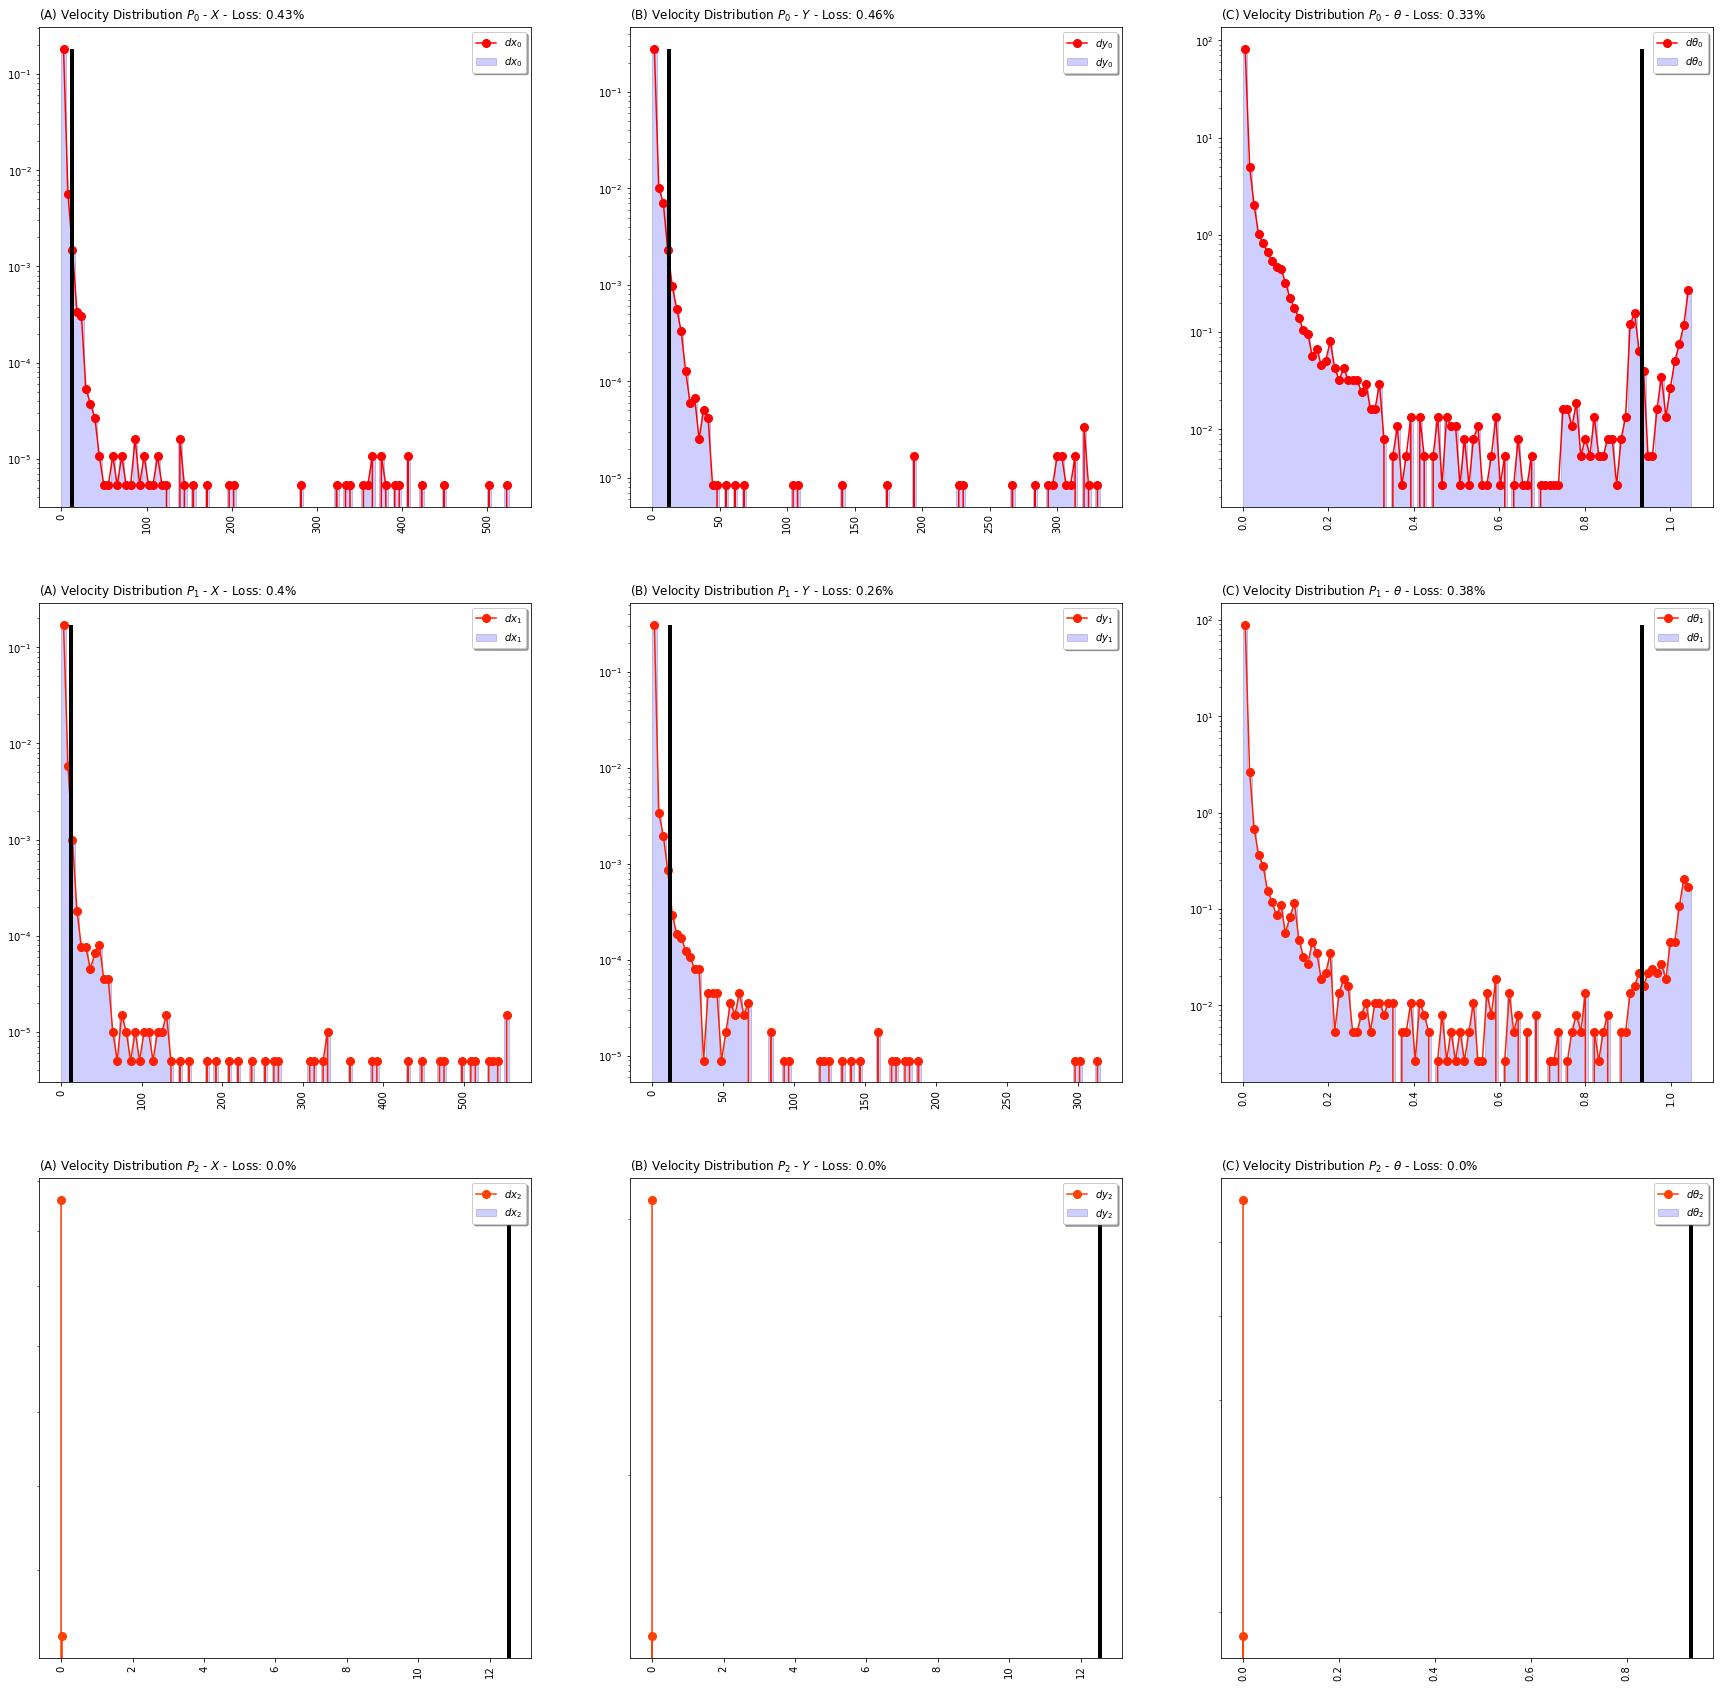

In [18]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [19]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [20]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1727.527664,495.458811,1727.658619,496.333293,NaN,1727.527664,495.458811,NaN,1727.527664,495.458811,-0.002989,4880.0,132.015826,62.921381,0.879109,2,NaN,NaN,NaN,NaN,False,False,False
2532,1,0,1570.642375,986.308463,1571.390783,984.520214,NaN,1570.642375,986.308463,NaN,1570.642375,986.308463,-1.543950,10374.0,222.382994,92.591304,0.909200,2,NaN,NaN,NaN,NaN,False,False,False
1,0,3,1727.514589,495.487452,1727.623350,496.364697,NaN,1727.514589,495.487452,NaN,1727.514589,495.487452,-0.007734,4901.0,131.849388,62.904680,0.878852,2,3.0,-0.004358,0.009547,-0.001582,False,False,False
2533,1,3,1571.040946,986.203573,1572.393670,984.357325,NaN,1571.040946,986.203573,NaN,1571.040946,986.203573,-1.543219,10355.0,219.997343,92.764577,0.906753,2,3.0,0.132857,-0.034963,0.000244,False,False,False
2,0,6,1727.522973,495.483766,1727.633026,496.359169,NaN,1727.522973,495.483766,NaN,1727.522973,495.483766,-0.007602,4897.0,131.785410,62.915471,0.878681,2,3.0,0.002795,-0.001229,0.000044,False,False,False
2534,1,6,1570.794689,986.134789,1572.115691,984.275019,NaN,1570.794689,986.134789,NaN,1570.794689,986.134789,-1.544316,10394.0,220.248104,92.660529,0.907195,2,3.0,-0.082086,-0.022928,-0.000366,False,False,False


## Visualize final data

In [21]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


In [22]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/2n_2m_0f_240216_1_c.zip'